### 1. Data Preperation

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path

#Scikit-learn - DS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by  ∼
 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

In [4]:
#step 1: Data preparation - Reading the csv file
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [221]:
df_initial

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


In [222]:
#Process the data with date
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [48]:
df_initial[df_initial['InvoiceNo'] == '536365']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom


In [49]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [50]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})

In [51]:
tab_info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object


In [57]:
# Create a DataFrame with null value counts
tab_info = pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'})

# Concatenate tab_info and df_null_counts
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'})])

display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
null values (nb),0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


In [58]:
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [223]:
#Processing the missing values by deleting all the na values. Depending on what you are going to analyze
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [73]:
# Create a DataFrame with null value counts
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})

tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'})])

# Concatenate tab_info and df_null_counts
tab_info = pd.concat([tab_info, pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'})])

display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


### Find duplicated all the rows can be appeared on your system

In [77]:
print('Entrées dupliquées: {}'.format(df_initial.duplicated().sum()))

Entrées dupliquées: 0


In [224]:
df_initial.drop_duplicates(inplace = True)

### Loading visualization


Countries Distribution

In [88]:
countries = df_initial['Country'].value_counts()

In [89]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
#temp = temp.reset_index(drop = False)

In [90]:
temp

Empty DataFrame
Columns: []
Index: [(12346, 541431, United Kingdom), (12346, C541433, United Kingdom), (12347, 537626, Iceland), (12347, 542237, Iceland), (12347, 549222, Iceland), (12347, 556201, Iceland), (12347, 562032, Iceland), (12347, 573511, Iceland), (12347, 581180, Iceland), (12348, 539318, Finland), (12348, 541998, Finland), (12348, 548955, Finland), (12348, 568172, Finland), (12349, 577609, Italy), (12350, 543037, Norway), (12352, 544156, Norway), (12352, 545323, Norway), (12352, 545332, Norway), (12352, 546869, Norway), (12352, 547390, Norway), (12352, 567505, Norway), (12352, 568699, Norway), (12352, 574275, Norway), (12352, C545329, Norway), (12352, C545330, Norway), (12352, C547388, Norway), (12353, 553900, Bahrain), (12354, 550911, Spain), (12355, 552449, Bahrain), (12356, 541430, Portugal), (12356, 549435, Portugal), (12356, 576895, Portugal), (12357, 574740, Switzerland), (12358, 559707, Austria), (12358, 581232, Austria), (12359, 540946, Cyprus), (12359, 543370, Cyprus), (12359, 555477, Cyprus), (12359, 571034, Cyprus), (12359, C549955, Cyprus), (12359, C580165, Cyprus), (12360, 554132, Austria), (12360, 563749, Austria), (12360, 571705, Austria), (12361, 545017, Belgium), (12362, 544203, Belgium), (12362, 551346, Belgium), (12362, 559295, Belgium), (12362, 563037, Belgium), (12362, 568651, Belgium), (12362, 570667, Belgium), (12362, 572887, Belgium), (12362, 573173, Belgium), (12362, 574329, Belgium), (12362, 580979, Belgium), (12362, C544902, Belgium), (12362, C563752, Belgium), (12362, C579178, Belgium), (12363, 549687, Unspecified), (12363, 563947, Unspecified), (12364, 563854, Belgium), (12364, 567897, Belgium), (12364, 573401, Belgium), (12364, 580152, Belgium), (12365, 544574, Cyprus), (12365, 544578, Cyprus), (12365, C544577, Cyprus), (12367, 580716, Denmark), (12370, 538826, Cyprus), (12370, 539330, Austria), (12370, 546236, Cyprus), (12370, 571905, Cyprus), (12371, 570521, Switzerland), (12371, 572770, Switzerland), (12372, 544157, Denmark), (12372, 552731, Denmark), (12372, 568872, Denmark), (12373, 542887, Austria), (12374, 576345, Austria), (12375, 565333, Finland), (12375, 579281, Finland), (12375, C581071, Finland), (12377, 539488, Switzerland), (12377, 542586, Switzerland), (12378, 562046, Switzerland), (12379, 557789, Belgium), (12379, 567196, Belgium), (12379, C559193, Belgium), (12380, 555739, Belgium), (12380, 567928, Belgium), (12380, 571187, Belgium), (12380, 577180, Belgium), (12380, C572532, Belgium), (12381, 563100, Norway), (12381, 570681, Norway), (12381, 570725, Norway), (12381, 574694, Norway), (12381, 580638, Norway), (12381, C565050, Norway), (12383, 539840, Belgium), ...]

[22190 rows x 0 columns]

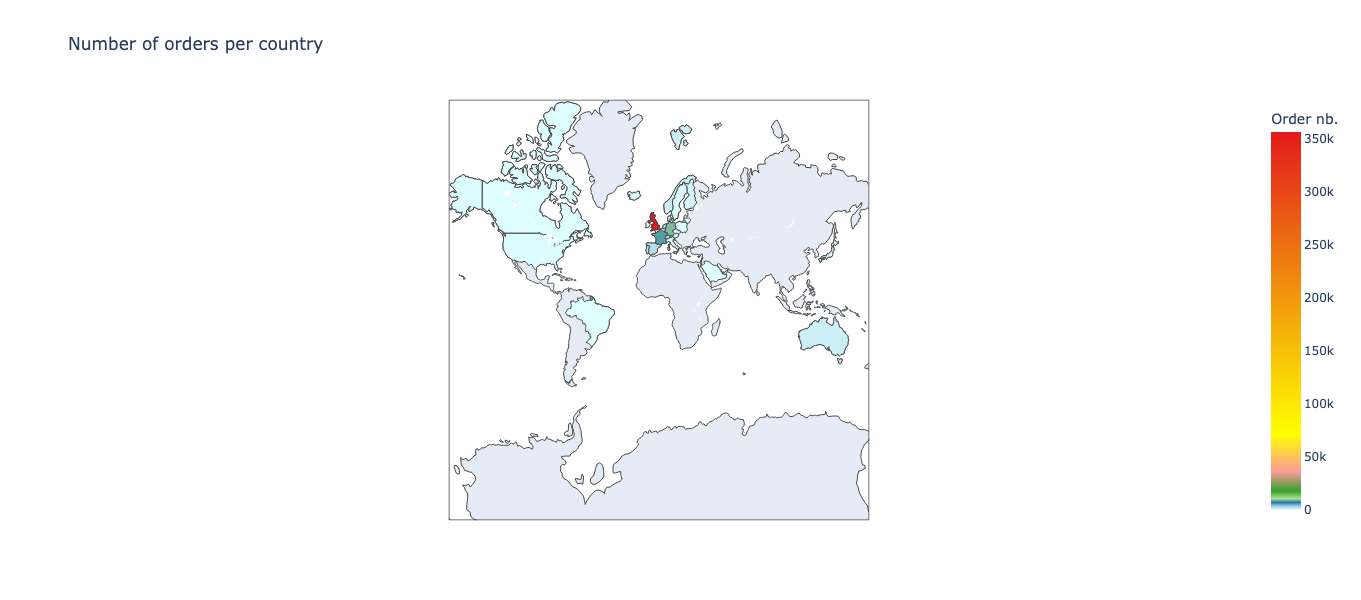

In [97]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',geo = dict(showframe = True, projection={'type':'mercator'}),width=1000,height=600)
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)


# We see that the dataset is largely dominated by orders made from the UK.

### Customers and products

In [105]:
df_initial[['Description', 'Quantity']]

,Description,Quantity
0,WHITE HANGING HEART T-LIGHT HOLDER,6
1,WHITE METAL LANTERN,6
2,CREAM CUPID HEARTS COAT HANGER,8
3,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,RED WOOLLY HOTTIE WHITE HEART.,6
...,...,...
541904,PACK OF 20 SPACEBOY NAPKINS,12
541905,CHILDREN'S APRON DOLLY GIRL,6
541906,CHILDRENS CUTLERY DOLLY GIRL,4
541907,CHILDRENS CUTLERY CIRCUS PARADE,4


### Groupby count the total quantity of the description of one product following the descending

In [113]:
pd.DataFrame(df_initial.groupby('Description')['Quantity'].sum()).nlargest(10, columns='Quantity')

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53119
JUMBO BAG RED RETROSPOT,44963
ASSORTED COLOUR BIRD ORNAMENT,35215
WHITE HANGING HEART T-LIGHT HOLDER,34128
PACK OF 72 RETROSPOT CAKE CASES,33386
POPCORN HOLDER,30492
RABBIT NIGHT LIGHT,27045
MINI PAINT SET VINTAGE,25880
PACK OF 12 LONDON TISSUES,25305


### Checking if total quantities of one product has been boughted by how many unique customers

In [114]:
pd.DataFrame(df_initial.groupby('Description').agg({'Quantity': 'sum', 'CustomerID': 'nunique'})).nlargest(10, columns='Quantity')

,Quantity,CustomerID
Description,,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53119,307
JUMBO BAG RED RETROSPOT,44963,636
ASSORTED COLOUR BIRD ORNAMENT,35215,679
WHITE HANGING HEART T-LIGHT HOLDER,34128,858
PACK OF 72 RETROSPOT CAKE CASES,33386,636
POPCORN HOLDER,30492,296
RABBIT NIGHT LIGHT,27045,450
MINI PAINT SET VINTAGE,25880,213
PACK OF 12 LONDON TISSUES,25305,195


In [130]:
filtered_data = pd.DataFrame(df_initial[['Description', 'CustomerID']][df_initial['Description'] == 'WORLD WAR 2 GLIDERS ASSTD DESIGNS'])

In [133]:
filtered_data['CustomerID'].nunique()

307

### The dataframe contains ∼ 400,000 entries. What are the number of users and products in these entries ? 

In [134]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


### Find which customer bought most

In [231]:
df_initial['TotalPrice'] = df_initial['Quantity'] * df_initial['UnitPrice']

In [139]:
df_initial.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [147]:
find_average = pd.DataFrame(df_initial.groupby(['CustomerID','Country']).agg({'TotalPrice': 'sum','InvoiceNo': 'count'})).nlargest(10, columns='TotalPrice')

In [148]:
#pd.DataFrame(df_initial.groupby(['CustomerID']).agg({'InvoiceNo': 'count'})).nlargest(10, columns='InvoiceNo')

In [150]:
find_average['Average'] = find_average['TotalPrice']/find_average['InvoiceNo']

In [153]:
find_average.nlargest(10, columns='TotalPrice')

,,TotalPrice,InvoiceNo,Average
CustomerID,Country,,,
14646,Netherlands,279489.02,2085,134.047492
18102,United Kingdom,256438.49,433,592.236697
17450,United Kingdom,187322.17,350,535.206200
14911,EIRE,132458.73,5898,22.458245
12415,Australia,123725.45,778,159.030141
14156,EIRE,113214.59,1415,80.010311
17511,United Kingdom,88125.38,1076,81.900911
16684,United Kingdom,65892.08,281,234.491388
13694,United Kingdom,62690.54,584,107.346815


In [154]:
find_average.nlargest(10, columns='Average')

,,TotalPrice,InvoiceNo,Average
CustomerID,Country,,,
18102,United Kingdom,256438.49,433,592.236697
17450,United Kingdom,187322.17,350,535.206200
16684,United Kingdom,65892.08,281,234.491388
12415,Australia,123725.45,778,159.030141
14646,Netherlands,279489.02,2085,134.047492
13694,United Kingdom,62690.54,584,107.346815
17511,United Kingdom,88125.38,1076,81.900911
14156,EIRE,113214.59,1415,80.010311
15311,United Kingdom,59284.19,2478,23.924209


In [156]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


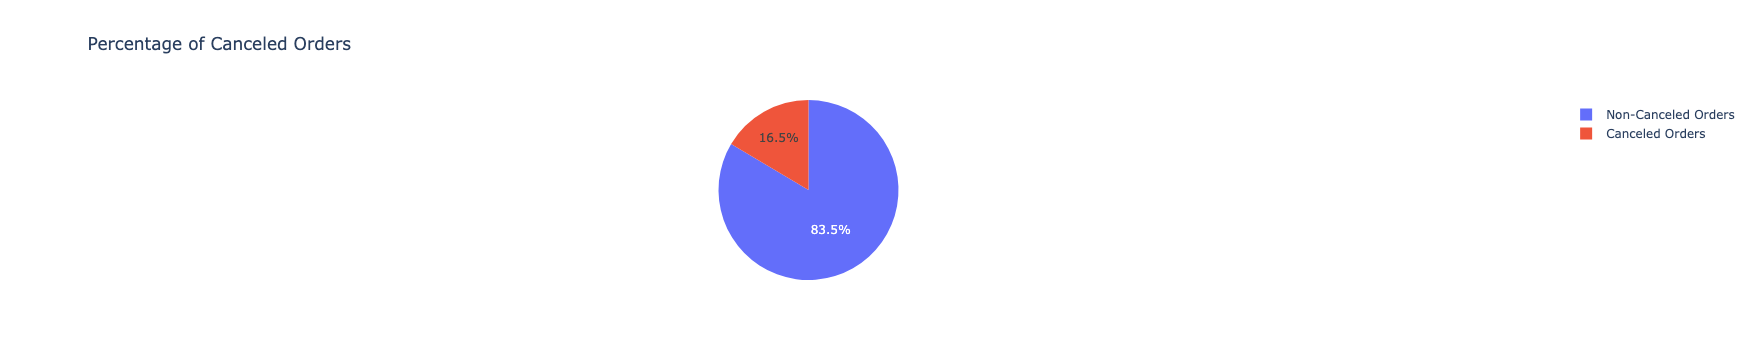

In [171]:
fig = go.Figure(data=[go.Pie(labels=['Canceled Orders', 'Non-Canceled Orders'], values=[n1/n2,(n2-n1)/n2])])

# Set the chart title
fig.update_layout(title='Percentage of Canceled Orders')

# Display the chart
fig.show()

In [172]:
nb_products_per_basket.nlargest(10, columns='order_canceled')

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1
40,12359,C580165,4,1
55,12362,C544902,2,1
56,12362,C563752,3,1
57,12362,C579178,3,1
66,12365,C544577,1,1


### From this the team can find out which customers have cancelled many times, also check the reason why they need to do that -> if there is any problem we can create another flag for finding the reason

In [175]:
#The reason can be listed as: fake customers, autonomaly detection, fradulant, network disconnection, hesitate customers.

### Next Problem -> Clear the canceled orders out of the data -> to make it become clearer

In [179]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]

In [180]:
df_check

,CustomerID,Quantity,StockCode,Description,UnitPrice
141,14527,-1,D,Discount,27.50
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
...,...,...,...,...,...
540449,14397,-11,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83
541541,15498,-1,M,Manual,224.69
541715,15311,-5,21258,VICTORIAN SEWING BOX LARGE,10.95
541716,17315,-1,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25


In [181]:
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [186]:
#nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
df_initial[df_initial['StockCode'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
87,536378,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-01 09:37:00,1.95,14688,United Kingdom,19.50
91,536378,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET,6,2010-12-01 09:37:00,3.75,14688,United Kingdom,22.50
121,536381,37444C,PINK BREAKFAST CUP AND SAUCER,1,2010-12-01 09:41:00,2.95,15311,United Kingdom,2.95
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
176,536386,85099C,JUMBO BAG BAROQUE BLACK WHITE,100,2010-12-01 09:57:00,1.65,16029,United Kingdom,165.00
...,...,...,...,...,...,...,...,...,...
540161,581469,51014C,"FEATHER PEN,COAL BLACK",12,2011-12-08 19:28:00,0.39,14606,United Kingdom,4.68
540375,581478,84997C,CHILDRENS CUTLERY POLKADOT BLUE,4,2011-12-09 08:59:00,4.15,17364,United Kingdom,16.60
541649,581538,85071C,"CHARLIE+LOLA""EXTREMELY BUSY"" SIGN",1,2011-12-09 11:34:00,0.39,14446,United Kingdom,0.39
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713,Germany,33.20


In [190]:
df_initial[df_initial['InvoiceNo']=='536378']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
86,536378,22386,JUMBO BAG PINK POLKADOT,10,2010-12-01 09:37:00,1.95,14688,United Kingdom,19.50
87,536378,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2010-12-01 09:37:00,1.95,14688,United Kingdom,19.50
88,536378,21033,JUMBO BAG CHARLIE AND LOLA TOYS,10,2010-12-01 09:37:00,2.95,14688,United Kingdom,29.50
89,536378,20723,STRAWBERRY CHARLOTTE BAG,10,2010-12-01 09:37:00,0.85,14688,United Kingdom,8.50
90,536378,84997B,RED 3 PIECE RETROSPOT CUTLERY SET,12,2010-12-01 09:37:00,3.75,14688,United Kingdom,45.00
91,536378,84997C,BLUE 3 PIECE POLKADOT CUTLERY SET,6,2010-12-01 09:37:00,3.75,14688,United Kingdom,22.50
92,536378,21094,SET/6 RED SPOTTY PAPER PLATES,12,2010-12-01 09:37:00,0.85,14688,United Kingdom,10.20
93,536378,20725,LUNCH BAG RED RETROSPOT,10,2010-12-01 09:37:00,1.65,14688,United Kingdom,16.50
94,536378,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,6,2010-12-01 09:37:00,2.55,14688,United Kingdom,15.30
95,536378,22352,LUNCH BOX WITH CUTLERY RETROSPOT,6,2010-12-01 09:37:00,2.55,14688,United Kingdom,15.30


In [232]:
#df_initial[df_initial['InvoiceNo']=='536378']['TotalPrice'].sum()
df_initial[~df_initial['StockCode'].str.contains('C') & (df_initial['InvoiceNo'] == '536378')]['TotalPrice'].sum()

402.98

In [233]:
df_initial[df_initial['InvoiceNo']=='536378']['TotalPrice'].sum()

444.98

In [234]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

In [235]:
df_check

,CustomerID,Quantity,StockCode,Description,UnitPrice
154,15311,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29
...,...,...,...,...,...
540449,14397,-11,23144,ZINC T-LIGHT HOLDER STARS SMALL,0.83
541541,15498,-1,M,Manual,224.69
541715,15311,-5,21258,VICTORIAN SEWING BOX LARGE,10.95
541716,17315,-1,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25


In [236]:
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [237]:
df_late = df_initial[~df_initial['StockCode'].str.contains('C')]

In [238]:
df_late[df_initial['InvoiceNo'] == '536378']['TotalPrice'].sum()

402.98

In [239]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

In [240]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,0
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,0


In [241]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,77183.60,2011-01-18 10:01:00.000000000
2,12347,537626,711.79,2010-12-07 14:57:00.000000000
3,12347,542237,475.39,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,2011-04-07 10:43:00.000000000
5,12347,556201,382.52,2011-06-09 13:01:00.000000000
6,12347,562032,584.91,2011-08-02 08:48:00.000000000


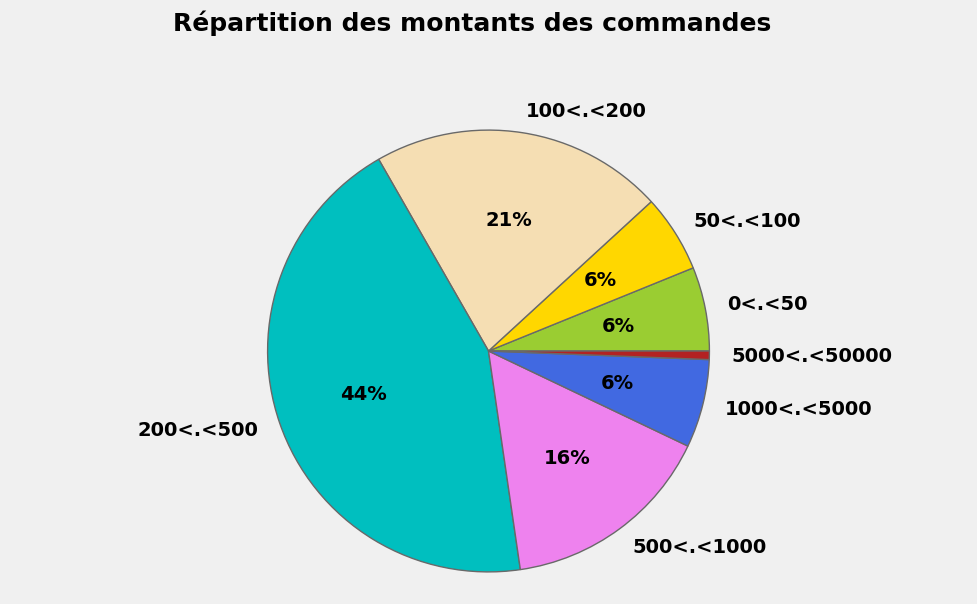

In [242]:
#____________________
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Répartition des montants des commandes", ha='center', fontsize = 18);

### check if there is any special letter in the StockCode value

In [191]:
list_special_codes = df_initial[df_initial['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

### Insight on product categories¶

In [244]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [245]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

In [246]:
df_produits

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3891,"LETTER ""W"" BLING KEY RING"
3892,"LETTER ""Z"" BLING KEY RING"
3893,PINK CRYSTAL SKULL PHONE CHARM
3894,CREAM HANGING HEART T-LIGHT HOLDER


In [247]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1483


In [248]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

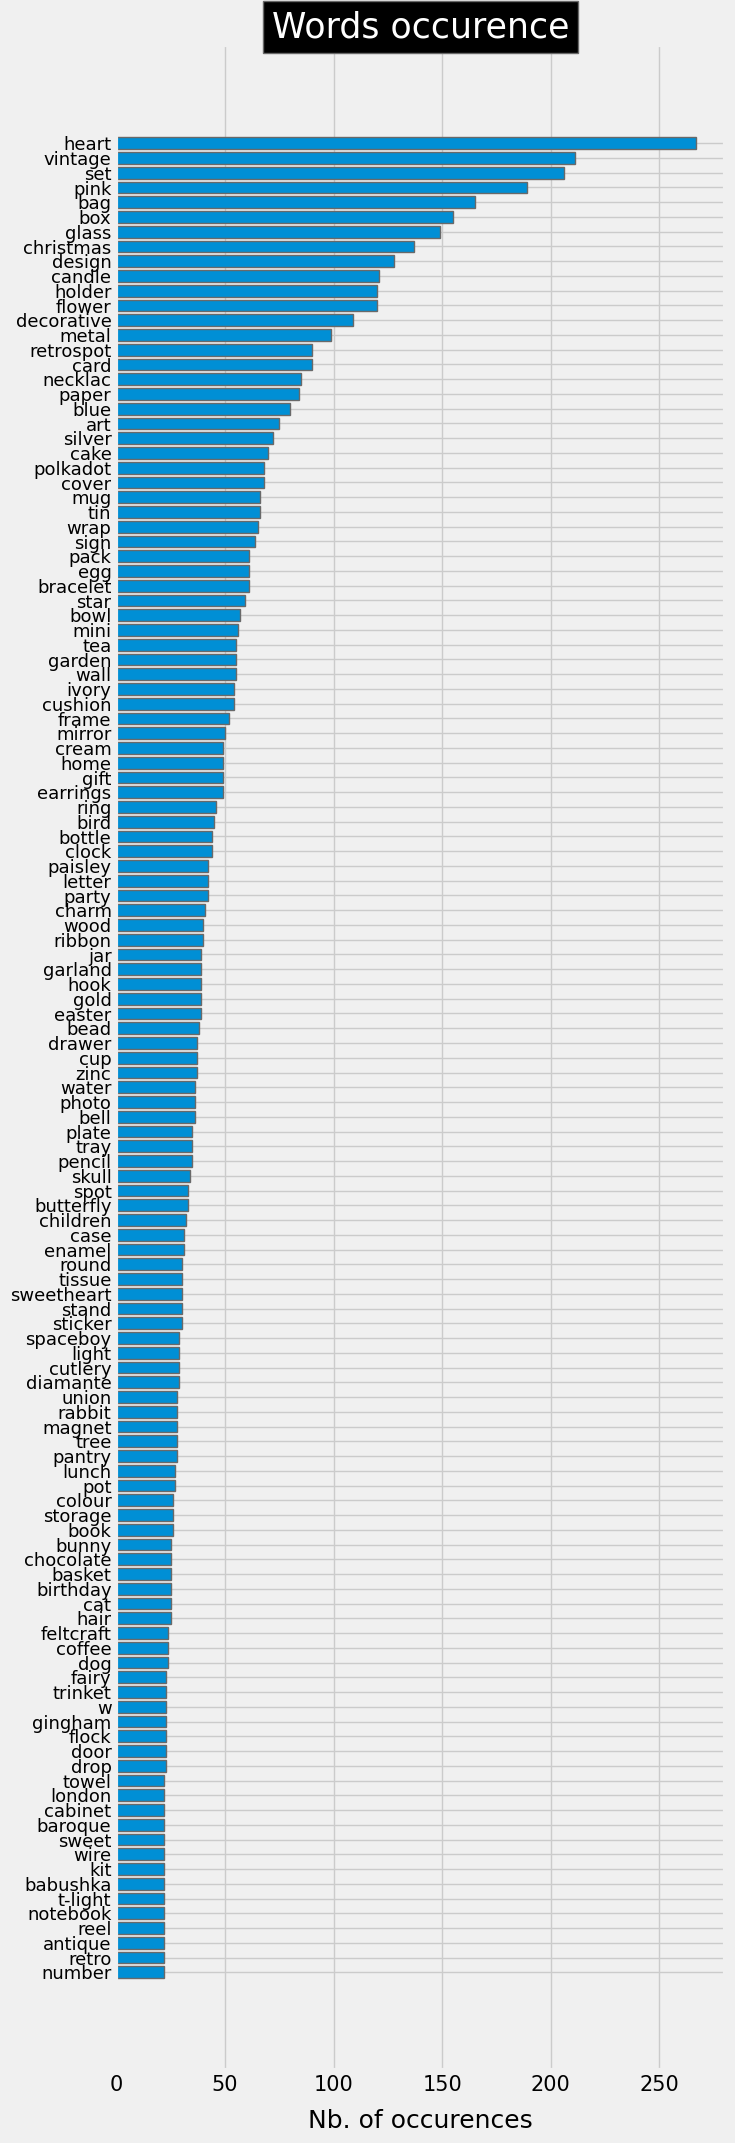

In [251]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()


In [253]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 193


### 4. Customer categories

4.1 Formatting data¶

In [255]:
df_initial[df_initial["InvoiceNo"] == "C541433"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.6


4.2 Let's examine the data more closely.

In [260]:
df_initial.loc[df_initial.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe().T

,count,mean,std,min,25%,50%,75%,max
UnitPrice,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [262]:
df[df["StockCode"] == "M"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom,1.25
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom,18.95
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723,United Kingdom,1.70
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062,United Kingdom,5.04
8530,537137,M,Manual,36,2010-12-05 12:43:00,0.85,16327,United Kingdom,30.60
...,...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2011-12-06 14:23:00,1.25,17841,United Kingdom,5.00
533082,C581009,M,Manual,-1,2011-12-07 09:15:00,125.00,16971,United Kingdom,-125.00
534308,C581145,M,Manual,-1,2011-12-07 13:48:00,9.95,17490,United Kingdom,-9.95
538321,581405,M,Manual,3,2011-12-08 13:50:00,0.42,13521,United Kingdom,1.26


In [264]:
df['canceled'] = list(map(lambda x: 'C' in str(x), df['InvoiceNo']))
canceled_orders = df[df['canceled'] == True]
canceled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,canceled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96,True


In [267]:
display(canceled_orders[["Quantity", "UnitPrice"]].describe().T)


,count,mean,std,min,25%,50%,75%,max
Quantity,8872.0,-30.774910,1172.249902,-80995.00,-6.00,-2.00,-1.00,-1.0
UnitPrice,8872.0,18.899512,445.190864,0.01,1.45,2.95,4.95,38970.0


📌 Need of Customer Segmentation

🛒 - It will help in identifying the most potential customers.

🛒 - It will help managers to easily communicate with a targetted group of the audience.

🛒 - Also, help in selecting the best medium for communicating with the targetted segment.

🛒 - It improves the quality of service, loyalty, and retention.

🛒 - Improve customer relationship via better understanding needs of segments.

🛒 - It will help managers to design special offers for targetted customers, to encourage them to buy more products.

🛒 - It also helps in identifying new products that customers could be interested in.


In [273]:
df_initial[df['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,canceled
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50,True
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96,True
...,...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,-9.13,True
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom,-224.69,True
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,-54.75,True
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,-1.25,True


In [284]:
df_new = df_initial[~df['InvoiceNo'].str.contains('C')]

In [285]:
df_new[df_new['Country'] == 'United Kingdom']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
...,...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804,United Kingdom,23.40,False
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113,United Kingdom,23.60,False
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113,United Kingdom,30.00,False
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113,United Kingdom,214.80,False


<AxesSubplot: >

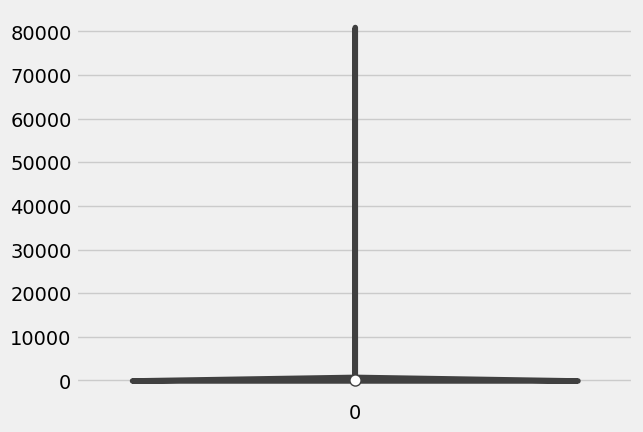

In [286]:
sns.violinplot(df_new.Quantity)

In [287]:
df_new.Quantity.describe()

count    392732.000000
mean         13.153718
std         181.588420
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [292]:
df_new = df_new[df_new['UnitPrice']>0]
df_new.UnitPrice.describe()

count    392692.000000
mean          3.125914
std          22.241836
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

In [293]:
df_new[df_new['UnitPrice']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,False
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,False
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,False
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,False


In [304]:
df_new['date'] = pd.DatetimeIndex(df_new.InvoiceDate).date
recency_df = df_new.groupby(['CustomerID'],as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346,2011-01-18
1,12347,2011-12-07
2,12348,2011-09-25
3,12349,2011-11-21
4,12350,2011-02-02


In [307]:
import datetime as dt
now = dt.date(2011,12,9)
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)

In [309]:
recency_df.head().nlargest(10, columns='Recency')

,CustomerID,LastPurchaseDate,Recency
0,12346,2011-01-18,325
4,12350,2011-02-02,310
2,12348,2011-09-25,75
3,12349,2011-11-21,18
1,12347,2011-12-07,2


In [310]:
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

In [320]:
frequency_df = df_new.copy()
frequency_df.drop_duplicates(subset=['CustomerID','InvoiceNo'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [321]:
df_new

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,canceled,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,False,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,False,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,False,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,False,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,False,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,False,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,False,2011-12-09


In [324]:
monetary_df = pd.DataFrame(df_new.groupby('CustomerID',as_index=False)['TotalPrice'].sum())

In [325]:
monetary_df.columns = ['CustomerID','Monetary']

### Monetary Values

In [326]:
monetary_df

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4333,18280,180.60
4334,18281,80.82
4335,18282,178.05
4336,18283,2045.53


### Frequency

In [329]:
frequency_df

,CustomerID,Frequency
0,12346,1
1,12347,7
2,12348,4
3,12349,1
4,12350,1
...,...,...
4333,18280,1
4334,18281,1
4335,18282,2
4336,18283,16


### Recency 

In [330]:
recency_df

,CustomerID,Recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310
...,...,...
4333,18280,277
4334,18281,180
4335,18282,7
4336,18283,3


In [332]:
#Combine all together all dataframe in so we have recency, frequency and monetary values together..

#combine first recency and frequency..
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

#combibe rf frame with monetary values..

rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm.set_index('CustomerID',inplace=True)

In [333]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,178.05


In [334]:
rfm_segmentation = rfm.copy()

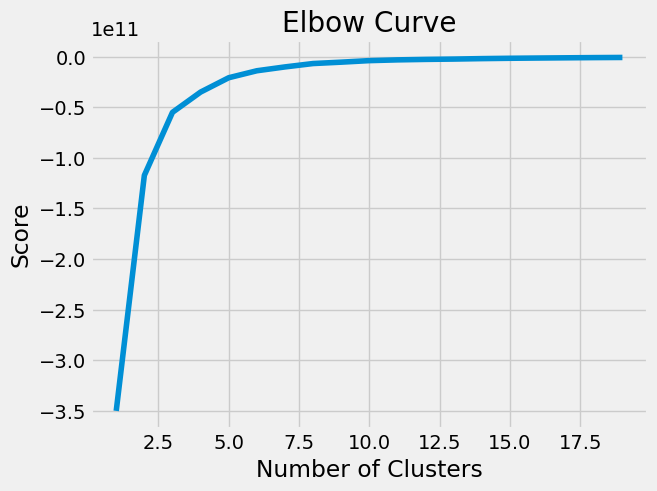

In [335]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [336]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)

In [338]:
rfm_segmentation['cluster'] = kmeans.labels_

In [340]:
rfm_segmentation

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346,325,1,77183.60,1
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,18,1,1757.55,0
12350,310,1,334.40,0
...,...,...,...,...
18280,277,1,180.60,0
18281,180,1,80.82,0
18282,7,2,178.05,0


In [342]:
rfm_segmentation[rfm_segmentation['cluster']==2]

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
14646,1,73,280206.02,2
14911,1,201,143711.17,2
16446,0,2,168472.50,2
17450,8,46,194390.79,2
18102,0,60,259657.30,2


In [344]:
rfm_segmentation[rfm_segmentation['cluster']==0]['Monetary'].info()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,18,1,1757.55,0
12350,310,1,334.40,0
12352,36,8,2506.04,0
...,...,...,...,...
18280,277,1,180.60,0
18281,180,1,80.82,0
18282,7,2,178.05,0


In [347]:
rfm_segmentation[rfm_segmentation['cluster']==0].describe()

,Recency,Frequency,Monetary,cluster
count,4301.000000,4301.000000,4301.000000,4301.0
mean,92.624971,3.901651,1438.723879,0.0
std,100.054541,4.996822,2254.396061,0.0
min,0.000000,1.000000,3.750000,0.0
25%,18.000000,1.000000,305.100000,0.0
50%,51.000000,2.000000,658.880000,0.0
75%,143.000000,5.000000,1614.910000,0.0
max,373.000000,93.000000,25977.160000,0.0


In [357]:
rfm_segmentation[rfm_segmentation['cluster']==0]#low monetery

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,18,1,1757.55,0
12350,310,1,334.40,0
12352,36,8,2506.04,0
...,...,...,...,...
18280,277,1,180.60,0
18281,180,1,80.82,0
18282,7,2,178.05,0


In [358]:
rfm_segmentation[rfm_segmentation['cluster']==1]#low monetery

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346,325,1,77183.60,1
12415,24,21,124914.53,1
12748,0,209,33053.19,1
12931,21,15,42055.96,1
13081,11,11,28337.38,1
13089,2,97,58762.08,1
13098,1,28,28882.44,1
13408,1,62,28117.04,1
13694,3,50,65039.62,1


In [359]:
rfm_segmentation[rfm_segmentation['cluster']==2]#low monetery

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
14646,1,73,280206.02,2
14911,1,201,143711.17,2
16446,0,2,168472.50,2
17450,8,46,194390.79,2
18102,0,60,259657.30,2


<AxesSubplot: xlabel='cluster', ylabel='Monetary'>

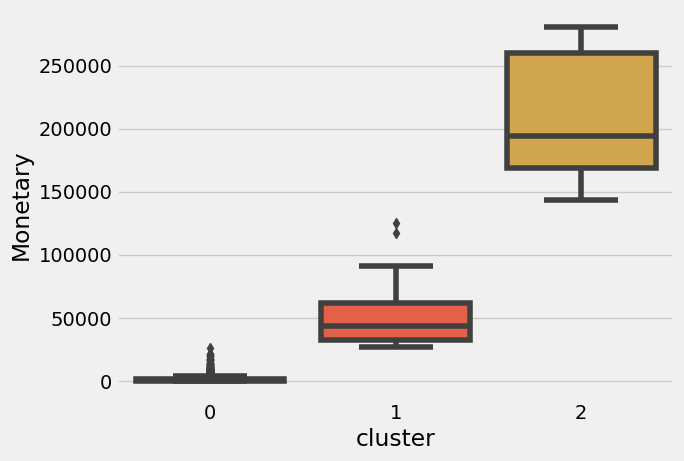

In [361]:
sns.boxplot(x=rfm_segmentation['cluster'], y=rfm_segmentation['Monetary'])

In [362]:
#lower the recency, good for store..
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [363]:
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [379]:
quantile = rfm.quantile(q=[0.25,0.5,0.75])
quantile

,Recency,Frequency,Monetary
0.25,17.00,1.0,306.4825
0.50,50.00,2.0,668.5700
0.75,141.75,5.0,1660.5975


In [365]:
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore,args=('Recency',quantile))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantile))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantile))

In [366]:
quantile.to_dict()

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.75},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 306.48249999999996, 0.5: 668.57, 0.75: 1660.5974999999999}}

In [367]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) + rfm_segmentation.F_Quartile.map(str) + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,,
12346,325,1,77183.60,1,4,4,1,441
12347,2,7,4310.00,0,1,1,1,111
12348,75,4,1797.24,0,3,2,1,321
12349,18,1,1757.55,0,2,4,1,241
12350,310,1,334.40,0,4,4,3,443


In [369]:
rfm_segmentation['Total_score'] = rfm_segmentation['R_Quartile'] + rfm_segmentation['F_Quartile'] + rfm_segmentation['M_Quartile']

In [370]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
12346,325,1,77183.60,1,4,4,1,441,9
12347,2,7,4310.00,0,1,1,1,111,3
12348,75,4,1797.24,0,3,2,1,321,6
12349,18,1,1757.55,0,2,4,1,241,7
12350,310,1,334.40,0,4,4,3,443,11


In [371]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==1]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==1]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='134']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='344']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))

Best Customers:  455
Loyal Customers:  872
Big Spenders:  1085
Almost Lost:  34
Lost Customers:  210
Lost Cheap Customers:  441


In [383]:
rfm_segmentation[rfm_segmentation['RFMScore']=='344']

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
12602,58,1,153.12,0,3,4,4,344,11
12641,115,1,185.90,0,3,4,4,344,11
12703,71,1,283.55,0,3,4,4,344,11
12718,71,1,238.25,0,3,4,4,344,11
12750,128,1,275.88,0,3,4,4,344,11
...,...,...,...,...,...,...,...,...,...
18255,89,1,103.30,0,3,4,4,344,11
18262,140,1,149.48,0,3,4,4,344,11
18268,134,1,25.50,0,3,4,4,344,11


In [372]:
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])

,Recency,Frequency,Monetary,cluster,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total_score
CustomerID,,,,,,,,,
14646,1,73,280206.02,2,1,1,1,111,3
18102,0,60,259657.30,2,1,1,1,111,3
17450,8,46,194390.79,2,1,1,1,111,3
14911,1,201,143711.17,2,1,1,1,111,3
14156,9,55,117210.08,1,1,1,1,111,3
...,...,...,...,...,...,...,...,...,...
17102,261,1,25.50,0,4,4,4,444,12
15823,372,1,15.00,0,4,4,4,444,12
17763,263,1,15.00,0,4,4,4,444,12


In [373]:
rfm_segmentation.groupby('RFMScore')['Monetary'].mean()

RFMScore
111    9546.480769
112    1283.713438
113     443.086667
114     201.120000
121    2913.640460
          ...     
434     210.831803
441    8910.267273
442     992.161026
443     412.326489
444     163.380317
Name: Monetary, Length: 61, dtype: float64

In [374]:
rfm_segmentation.groupby('Total_score')['Monetary'].mean()

Total_score
3     9546.480769
4     4153.533225
5     2420.353215
6     1456.222749
7     1193.794679
8      781.487600
9      713.177336
10     382.106514
11     286.982198
12     163.380317
Name: Monetary, dtype: float64

<AxesSubplot: xlabel='Total_score'>

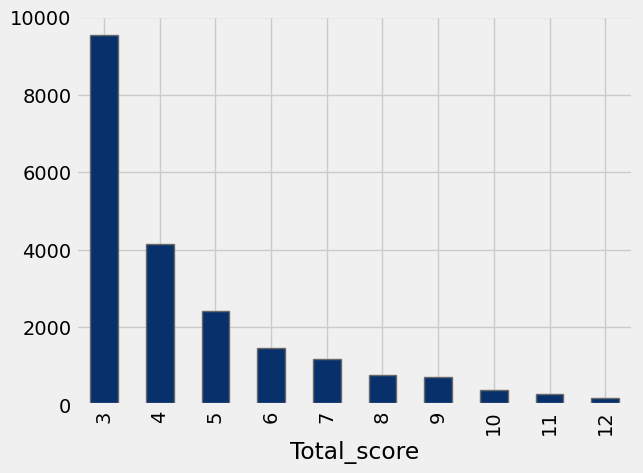

In [375]:
'''
Based on Monetary we see Total_score 3,4,5 have highest value which is good for model. because it could have
combination of values such as 111, 121, 122 etc.
'''
rfm_segmentation.groupby('Total_score')['Monetary'].mean().plot(kind='bar', colormap='Blues_r')

<AxesSubplot: xlabel='Total_score'>

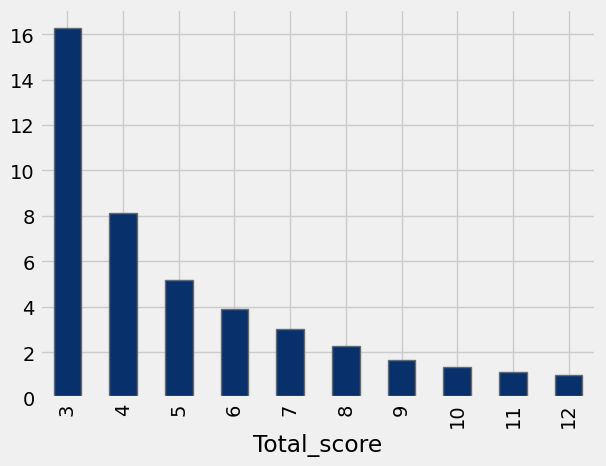

In [376]:
'''
Based on Frequncy we see Total_score 3,4,5 have highest value which is good for model. because it could have
combination of values such as 111, 121, 122 etc.
'''
rfm_segmentation.groupby('Total_score')['Frequency'].mean().plot(kind='bar', colormap='Blues_r')


<AxesSubplot: xlabel='Total_score'>

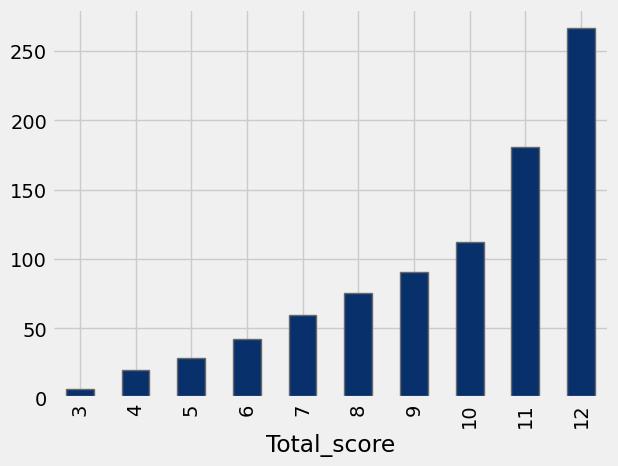

In [378]:
'''
Based on Recency we see Total_score 10,11,12 have highest value which is good for model. because it could have
combination of values such as 444, 434, 334 etc.
'''

rfm_segmentation.groupby('Total_score')['Recency'].mean().plot(kind='bar', colormap='Blues_r')
